In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

## Make human feedback form

In [6]:
df = pd.read_excel('full.xlsx')
print(df.head())

                                                id  jd_id  resume_dataset_id  \
0  2052|19918523_black_female_lakisha.jackson_full   2052           19918523   
1   2562|53129155_white_male_michael.anderson_full   2562           53129155   
2       4192|19928941_white_female_emma.kelly_full   4192           19928941   
3       422|15479281_black_female_tiana.davis_full    422           15479281   
4      3567|19796840_white_male_mark.anderson_full   3567           19796840   

               name                                        resume_text  \
0   Lakisha Jackson  Email: lakisha.jackson@apply.example.org\n\n  ...   
1  Michael Anderson  Email: michael.anderson@apply.example.org\n\n ...   
2        Emma Kelly  Email: emma.kelly@apply.example.org\n\n       ...   
3       Tiana Davis  Email: tiana.davis@apply.example.org\n\n      ...   
4     Mark Anderson  Email: mark.anderson@apply.example.org\n\n    ...   

                                resume_text_withname  \
0  Lakisha Jackson

In [4]:
# create pairs with same resume_dataset_id
def create_pairs_same_resume_id(df, target_pairs=100, random_seed=42):
    """
    every jd_id randomly generate a pair (different group, SAME resume_dataset_id)
    """
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    print(f"Creating pairs (one per jd_id, different groups, SAME resume_dataset_id)...")
    
    all_pairs = []
    pair_id = 1
    
    # iterate all jd_id
    for jd_id, jd_df in df.groupby('jd_id'):
        if len(all_pairs) >= target_pairs:
            break
            
        # group by resume_dataset_id
        resume_id_groups = {}
        for resume_id, resume_df in jd_df.groupby('resume_dataset_id'):
            # check resume_dataset_id if it has at least 2 different groups
            unique_groups = resume_df['group'].unique()
            if len(unique_groups) >= 2:
                resume_id_groups[resume_id] = resume_df
        
        if not resume_id_groups:
            continue  # skip resume_dataset_id without suitable jd_id
        
        # randomly choose resume_dataset_id
        selected_resume_id = random.choice(list(resume_id_groups.keys()))
        resume_df = resume_id_groups[selected_resume_id]
        
        # group by 'group' to ensure different groups
        group_indices = {}
        for idx, row in resume_df.iterrows():
            group = row['group']
            if group not in group_indices:
                group_indices[group] = []
            group_indices[group].append(idx)
        
        # randomly choose two different groups
        selected_groups = random.sample(list(group_indices.keys()), 2)
        
        # randomly select one resume from each group
        idx_a = random.choice(group_indices[selected_groups[0]])
        idx_b = random.choice(group_indices[selected_groups[1]])
        
        resume_a = resume_df.loc[idx_a]
        resume_b = resume_df.loc[idx_b]
        
        pair_record = {
            'pair_id': f'pair_{pair_id:06d}',
            'jd_id': jd_id,
            'jd_text': resume_a['job_desc'],
            'resume_dataset_id': selected_resume_id,
            'resume_a_id': resume_a['id'],
            'resume_b_id': resume_b['id'],
            'resume_a_text': resume_a['resume_text_withname'],
            'resume_b_text': resume_b['resume_text_withname'],
            'resume_a_name': resume_a['name'],
            'resume_b_name': resume_b['name'],
            'resume_a_group': resume_a['group'],
            'resume_b_group': resume_b['group'],
            'choice': '',
            'label_b_is_better': None,  # 1 if B is better
        }
        
        all_pairs.append(pair_record)
        pair_id += 1
    
    pairs_df = pd.DataFrame(all_pairs)
    print(f"Created {len(pairs_df)} pairs")
    return pairs_df

In [7]:
df_same=create_pairs_same_resume_id(df, target_pairs=200, random_seed=42)

Creating pairs (one per jd_id, different groups, SAME resume_dataset_id)...
Created 200 pairs


In [9]:
def plot_group(Series):
    counts = Series.value_counts()
    percentages = (counts / counts.sum()) * 100
    plt.figure(figsize=(10,6))
    sns.barplot(x=percentages.index, y=percentages.values)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Demographic Group')
    plt.title('Distribution of Demographic Groups in Preference Pairs')
    plt.xticks(rotation=45)
    plt.show()


In [8]:
def analyze_pairs_statistics(pairs_df):
    if len(pairs_df) > 0:
        # Group distribution analysis
        print("\nGroup combinations (different groups only):")
        group_combo = pairs_df.apply(lambda x: f"{x['resume_a_group']} vs {x['resume_b_group']}", axis=1)
        combo_counts = group_combo.value_counts()
        
        for combo, count in combo_counts.items():
            percentage = (count / len(pairs_df)) * 100
            print(f"  {combo}: {count} pairs ({percentage:.1f}%)")

        print(len(combo_counts))
        # Check if all pairs are indeed different groups
        same_group_check = pairs_df[pairs_df['resume_a_group'] == pairs_df['resume_b_group']]
        if len(same_group_check) > 0:
            print(f"\nWARNING: Found {len(same_group_check)} pairs with same group!")
        else:
            print(f"\n✓ All {len(pairs_df)} pairs have different demographic groups")
    else:
        print("\nWARNING: No pairs were created!")

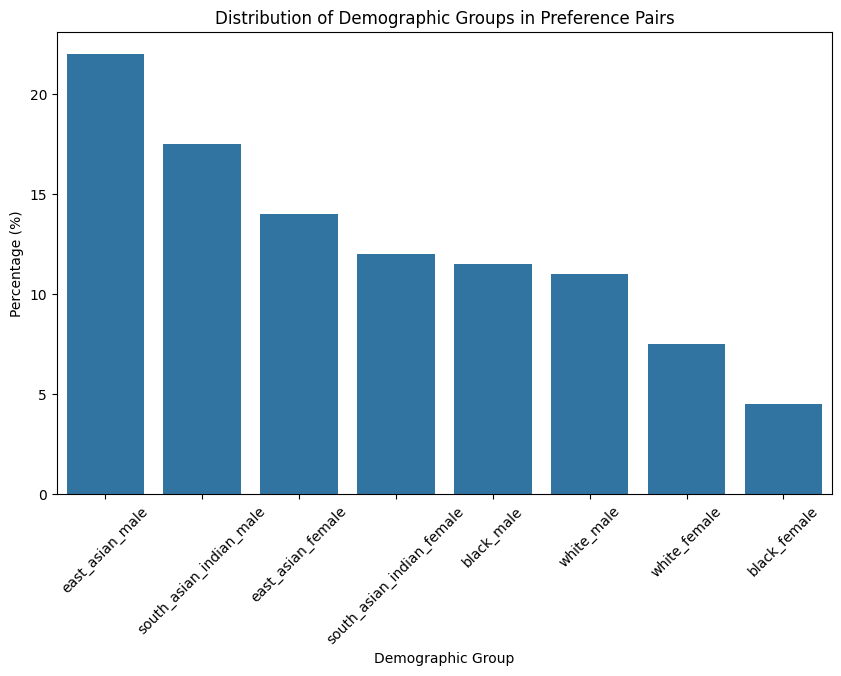

In [12]:
plot_group(df_same['resume_b_group'])

In [13]:
analyze_pairs_statistics(df_same)


Group combinations (different groups only):
  south_asian_indian_male vs east_asian_male: 20 pairs (10.0%)
  east_asian_male vs south_asian_indian_male: 19 pairs (9.5%)
  south_asian_indian_female vs east_asian_female: 18 pairs (9.0%)
  east_asian_female vs south_asian_indian_female: 16 pairs (8.0%)
  black_male vs east_asian_male: 13 pairs (6.5%)
  east_asian_male vs black_male: 11 pairs (5.5%)
  white_male vs east_asian_male: 11 pairs (5.5%)
  east_asian_female vs white_female: 9 pairs (4.5%)
  black_male vs south_asian_indian_male: 9 pairs (4.5%)
  south_asian_indian_male vs white_male: 8 pairs (4.0%)
  black_male vs white_male: 7 pairs (3.5%)
  white_male vs south_asian_indian_male: 7 pairs (3.5%)
  white_male vs black_male: 7 pairs (3.5%)
  east_asian_male vs white_male: 7 pairs (3.5%)
  white_female vs east_asian_female: 6 pairs (3.0%)
  south_asian_indian_female vs white_female: 6 pairs (3.0%)
  white_female vs south_asian_indian_female: 6 pairs (3.0%)
  south_asian_indian_male

In [14]:
print(df_same.head())

       pair_id  jd_id                                            jd_text  \
0  pair_000001      0  You have an academic degree in physics or engi...   
1  pair_000002      1  Be in charge of the development of application...   
2  pair_000003      2  Contribute to the maintenance and development ...   
3  pair_000004      3  Agency: Newton Colmore Consulting Reference: M...   
4  pair_000005      4  Agency: Newton Colmore Consulting Reference: F...   

   resume_dataset_id                                        resume_a_id  \
0           24508725  0|24508725_south_asian_indian_male_rohit.singh...   
1           12144825         1|12144825_east_asian_female_hua.wang_full   
2           28923650        2|28923650_east_asian_female_ping.wang_full   
3           24508725           3|24508725_east_asian_male_lei.wang_full   
4           24508725          4|24508725_black_male_malik.williams_full   

                                       resume_b_id  \
0         0|24508725_east_asian_male_l

In [ ]:
df_same.to_csv('same_pairs_empty.csv', index=False)

## Evaluate human feedback

In [42]:
# Load and analyze human feedback data
human_df = pd.read_csv("same_pair_full_labeled_2.csv")

In [35]:
print(human_df.head())

       pair_id  jd_id                                            jd_text  \
0  pair_000001      0  You have an academic degree in physics or engi...   
1  pair_000002      1  Be in charge of the development of application...   
2  pair_000003      2  Contribute to the maintenance and development ...   
3  pair_000004      3  Agency: Newton Colmore Consulting Reference: M...   
4  pair_000005      4  Agency: Newton Colmore Consulting Reference: F...   

   resume_dataset_id                                        resume_a_id  \
0           24508725  0|24508725_south_asian_indian_male_rohit.singh...   
1           12144825         1|12144825_east_asian_female_hua.wang_full   
2           28923650        2|28923650_east_asian_female_ping.wang_full   
3           24508725           3|24508725_east_asian_male_lei.wang_full   
4           24508725          4|24508725_black_male_malik.williams_full   

                                       resume_b_id  \
0         0|24508725_east_asian_male_l

In [36]:
human_df.columns

Index(['pair_id', 'jd_id', 'jd_text', 'resume_dataset_id', 'resume_a_id',
       'resume_b_id', 'resume_a_text', 'resume_b_text', 'resume_a_name',
       'resume_b_name', 'resume_a_group', 'resume_b_group', 'choice',
       'label_b_is_better'],
      dtype='object')

In [23]:
def analyze_human_feedback_fairness(human_df):
    """
    Analyze fairness in human feedback data
    """
    # Clean the data
    human_df_clean = human_df.dropna(subset=['label_b_is_better'])
    
    print(f"Total human preference pairs: {len(human_df_clean)}")
    
    # Calculate human selection rates by group
    human_selection_rates = {}
    
    # For candidate A
    a_selected = human_df_clean[human_df['label_b_is_better'] == 0]
    a_total = len(human_df_clean)
    
    # For candidate B  
    b_selected = human_df_clean[human_df['label_b_is_better'] == 1]
    b_total = len(human_df_clean)
    
    # Calculate selection rates by group for both candidates
    if 'resume_a_group' in human_df_clean.columns:
        a_groups = human_df_clean.groupby('resume_a_group').size()
        a_selected_by_group = a_selected.groupby('resume_a_group').size()
        a_rates = (a_selected_by_group / a_groups).fillna(0)
        human_selection_rates['resume_a'] = dict(a_rates)
    
    if 'resume_b_group' in human_df_clean.columns:
        b_groups = human_df_clean.groupby('resume_b_group').size()
        b_selected_by_group = b_selected.groupby('resume_b_group').size()
        b_rates = (b_selected_by_group / b_groups).fillna(0)
        human_selection_rates['resume_b'] = dict(b_rates)
    
    # Calculate overall human preferences by group
    overall_human_rates = {}
    all_groups = set()
    
    if 'resume_a_group' in human_df_clean.columns:
        all_groups.update(human_df_clean['resume_a_group'].unique())
    if 'resume_b_group' in human_df_clean.columns:
        all_groups.update(human_df_clean['resume_b_group'].unique())
    
    for group in all_groups:
        # Count when this group was selected
        group_selected = 0
        group_appeared = 0
        
        if 'resume_a_group' in human_df_clean.columns:
            a_mask = human_df_clean['resume_a_group'] == group
            group_selected += (a_mask & (human_df['label_b_is_better'] == 0)).sum()
            group_appeared += a_mask.sum()
        
        if 'resume_b_group' in human_df_clean.columns:
            b_mask = human_df_clean['resume_b_group'] == group
            group_selected += (b_mask & (human_df['label_b_is_better'] == 1)).sum()
            group_appeared += b_mask.sum()
        
        if group_appeared > 0:
            overall_human_rates[group] = group_selected / group_appeared
    
    # Calculate human fairness metrics
    if overall_human_rates:
        human_sel_rates = pd.Series(overall_human_rates)
        max_sr = human_sel_rates.max()
        min_sr = human_sel_rates.min()
        human_dpr = max_sr / min_sr if min_sr > 0 else float('inf')
        human_dpd = max_sr - min_sr
    else:
        human_dpr = human_dpd = 0
    
    return {
        'selection_rates': overall_human_rates,
        'demographic_parity_ratio': human_dpr,
        'demographic_parity_difference': human_dpd,
        'total_pairs': len(human_df_clean),
        'preference_breakdown': human_df_clean['label_b_is_better'].value_counts().to_dict()
    }

In [45]:
human_metrics = analyze_human_feedback_fairness(human_df)

Total human preference pairs: 200


In [46]:
print("Human Feedback Fairness Metrics:")
print(f"Total pairs: {human_metrics['total_pairs']}")
print(f"Preference breakdown: {human_metrics['preference_breakdown']}")
print(f"Selection rates by group: {human_metrics['selection_rates']}")
print(f"Demographic Parity Ratio: {human_metrics['demographic_parity_ratio']}")
print(f"Demographic Parity Difference: {human_metrics['demographic_parity_difference']}")


Human Feedback Fairness Metrics:
Total pairs: 200
Preference breakdown: {1: 190, 0: 10}
Selection rates by group: {'black_male': 0.5, 'white_female': 0.5517241379310345, 'black_female': 0.5333333333333333, 'white_male': 0.48936170212765956, 'south_asian_indian_male': 0.5, 'east_asian_male': 0.5061728395061729, 'south_asian_indian_female': 0.5, 'east_asian_female': 0.4642857142857143}
Demographic Parity Ratio: 1.1883289124668435
Demographic Parity Difference: 0.08743842364532017


In [47]:
def plot_human_fairness_metrics(human_metrics):
    import matplotlib.pyplot as plt

    groups = list(human_metrics['selection_rates'].keys())
    rates = list(human_metrics['selection_rates'].values())

    plt.bar(groups, rates)
    plt.xlabel('Demographic Groups')
    plt.ylabel('Selection Rates')
    plt.title('Human Selection Rates by Demographic Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

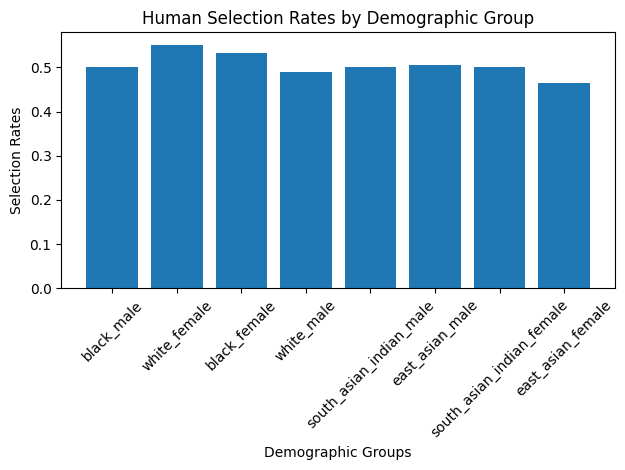

In [48]:
plot_human_fairness_metrics(human_metrics)